## Adapting Open Global Glacier Model (OGGM) for use in Nevados de Chillán, Chile 

![OGGM Logo](https://docs.oggm.org/en/stable/_static/logos/oggm_dark_s_alpha.png)

* To set up: mamba env create -f environment.yml
* to update:  pip install --upgrade git+https://github.com/OGGM/oggm.git
* run: conda install -c conda-forge mamba; mamba activate oggm_env
* cd /workspaces/oggm_redo
* Using oggm_env (Python 3.12.2) kernel 
* git pull upstream master (pulls from the OGGM repo) 
* git merge to merge (duh) my stream with theirs 

In [1]:
import oggm 
from oggm import cfg
# It will download a small subset of data used for testing and calibration 
# Those data are located in your home directory, in a hidden folder called .oggm

cfg.initialize()
# It will create a configuration file in your home folder, where you can indicate where you want to store further input data. 
# This configuration file is also located in your home directory under the name .oggm_config.

Matplotlib is building the font cache; this may take a moment.


2024-07-26 18:14:39: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-07-26 18:14:39: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-07-26 18:14:39: oggm.cfg: Multiprocessing: using all available processors (N=8)
2024-07-26 18:14:40: oggm.utils: Downloading https://github.com/OGGM/oggm-sample-data/archive/c6b64892b6da37b8b43c83e2cb148e9872d34f48.zip to /Users/milliespencer/OGGM/download_cache/github.com/OGGM/oggm-sample-data/archive/c6b64892b6da37b8b43c83e2cb148e9872d34f48.zip...
/   0.0 B Elapsed Time: 0:00:00
|  -1.0 B Elapsed Time: 0:00:01
2024-07-26 18:14:42: oggm.utils: Checking the download verification file checksum...
2024-07-26 18:14:43: oggm.utils: Downloading https://cluster.klima.uni-bremen.de/data/downloads.sha256.hdf to /Users/milliespencer/.oggm/downloads.sha256.hdf...
2024-07-26 18:14:48: oggm.utils: Done downloading.
2024-07-26 18:14:48: oggm.utils: Checking the download verification file checksum...

In [2]:
# To locate this config file: (prints location: '/home/codespace/.oggm_config')
cfg.CONFIG_FILE

'/Users/milliespencer/.oggm_config'

In [3]:
from oggm import cfg, utils
cfg.initialize(logging_level='WARNING')
# A call to cfg.initialize() will read the default parameter file (or any user-provided file) and
# make them available to all other OGGM tools via the cfg.PARAMS dictionary. 

2024-07-26 18:15:03: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-07-26 18:15:03: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-07-26 18:15:03: oggm.cfg: Multiprocessing: using all available processors (N=8)


In [4]:
cfg.PARAMS['melt_f'], cfg.PARAMS['ice_density'], cfg.PARAMS['continue_on_error']

(5.0, 900.0, False)

In [5]:
# You can try with or without multiprocessing: with two glaciers, OGGM could run on two processors
cfg.PARAMS['use_multiprocessing'] = True

2024-07-26 18:15:07: oggm.cfg: Multiprocessing switched ON after user settings.


## Working through a mock workflow
Each OGGM run needs a single folder where to store the results of the computations for all glaciers. This is called a “working directory” and needs to be specified before each run. Here we create a temporary folder for you:

In [ ]:
# create temporary folder as working directory 
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-GettingStarted-10m', reset=True)
cfg.PATHS['working_dir']

# creating a permanent folder as working directory: 
# e.g. /home/shruti/OGGM_output

'/tmp/OGGM/OGGM-GettingStarted-10m'

## ^ come back and make folder permanant!! 

In the OGGM design, this working directory is meant to be persistent, at least as long as you need the data. For example, you can stop your processing workflow after any task, and restart from an existing working directory at a later stage, simply by using the same working directory.

In [8]:
# define the glaciers for the run 
# example glaciers from the tutorial 
rgi_ids = ['RGI60-11.01328', 'RGI60-11.00897'] 
# main glacier on nevados de chillán
glaciar_nevado = ['RGI60-17.13045']

For an operational run on an RGI region, you might want to download the Randolph Glacier Inventory dataset instead, and start a run from it. This case is covered in the working with the RGI tutorial.

## Glacier directories

The OGGM workflow is organized as a list of tasks that have to be applied to a list of glaciers. The vast majority of tasks are called entity tasks: they are standalone operations to be realized on one single glacier entity. These tasks are executed sequentially (one after another): they often need input generated by the previous task(s): for example, the climate calibration needs the glacier flowlines, which can be only computed after the topography data has been processed, and so on.

To handle this situation, OGGM uses a workflow based on data persistence on disk: instead of passing data as python variables from one task to another, each task will read the data from disk and then write the computation results back to the disk, making these new data available for the next task in the queue. These glacier specific data are located in glacier directories.

In [9]:
# One main advantage of this workflow is that OGGM can prepare data and make it available to everyone! Here is an example of an url where such data can be found:
from oggm import workflow
from oggm import DEFAULT_BASE_URL
DEFAULT_BASE_URL

'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/elev_bands/W5E5_spinup'

In [10]:
# Let’s use OGGM to download the glacier directories for our two selected glaciers:
gdirs = workflow.init_glacier_directories(
    rgi_ids,  # which glaciers?
    prepro_base_url=DEFAULT_BASE_URL,  # where to fetch the data?
    from_prepro_level=4,  # what kind of data? 
    prepro_border=80  # how big of a map?
)

2024-07-25 17:37:15: oggm.workflow: init_glacier_directories from prepro level 4 on 2 glaciers.
2024-07-25 17:37:15: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 2 glaciers
  0% of 261.6 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
100% of 261.6 MiB |######################| Elapsed Time: 0:00:14 Time:  0:00:14
  0% of 267.5 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
100% of 267.5 MiB |######################| Elapsed Time: 0:00:14 Time:  0:00:14


In [11]:
# What if we duplicate the above cell for glaciar nevado? 
nevado_gdir = workflow.init_glacier_directories(
    glaciar_nevado,  # which glaciers?
    prepro_base_url=DEFAULT_BASE_URL,  # where to fetch the data?
    from_prepro_level=4,  # what kind of data? 
    prepro_border=80  # how big of a map?
)

2024-07-25 17:37:46: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2024-07-25 17:37:46: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
  0% of 318.6 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
 85% of 318.6 MiB |##################    | Elapsed Time: 0:00:15 ETA:   0:00:02
100% of 318.6 MiB |######################| Elapsed Time: 0:00:17 Time:  0:00:17


* the keyword from_prepro_level indicates that we will start from pre-processed directories, i.e. data that are already prepared by the OGGM team. In many cases you will want to start from pre-processed directories, in most case from level 3 or 5. For level 3 and above the model has already been calibrated, so you no longer need to do that yourself and can start rigth away with your simulation. Here we start from level 4 and add some data to the processing in order to demonstrate the OGGM workflow.

* the prepro_border keyword indicates the number of grid points which we’d like to add to each side of the glacier for the local map: the larger the glacier will grow, the larger the border parameter should be. The available pre-processed border values are: 10, 80, 160, 240 (depending on the model set-ups there might be more or less options). These are the fixed map sizes we prepared for you - any other map size will require a full processing (see the further DEM sources example for a tutorial).

In [12]:
# The init_glacier_directories task will allways be the very first task to call for all your OGGM experiments. 
# Let’s see what it gives us back:

type(gdirs), type(gdirs[0])

# gdirs is a list of GlacierDirectory objects (one for each glacier). 
# Glacier directories are used by OGGM as “file and attribute manager” for single glaciers. 

# For nevado 
type(nevado_gdir), type(nevado_gdir[0])

(list, oggm.utils._workflow.GlacierDirectory)

In [13]:
# For example, the model now knows where to find the topography data file for this glacier:
gdir = gdirs[0]  # take Unteraar glacier
print('Path to the DEM:', gdir.get_filepath('dem'))

# path to the glaciar nevado dem: 
nevado_gdir = nevado_gdir[0]
print('Path to the DEM:', nevado_gdir.get_filepath('dem'))
# don't get why i needed the [0] since there's only one glacier in the list but ok.. 

Path to the DEM: /tmp/OGGM/OGGM-GettingStarted-10m/per_glacier/RGI60-11/RGI60-11.01/RGI60-11.01328/dem.tif
Path to the DEM: /tmp/OGGM/OGGM-GettingStarted-10m/per_glacier/RGI60-17/RGI60-17.13/RGI60-17.13045/dem.tif


In [14]:
# And we can also access some attributes of this glacier:
gdir
nevado_gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-17.13045
  Region: 17: Southern Andes
  Subregion: 17-02: C Andes                         
  Glacier type: Ice cap
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 1.256 km2
  Lon, Lat: (-71.4149, -36.8356)
  Grid (nx, ny): (219, 217)
  Grid (dx, dy): (26.0, -26.0)

In [15]:
gdir.rgi_date  # date at which the outlines are valid
nevado_gdir.rgi_date
# nevado outline only valid for 2000, quite old/out of date 

2000

The advantage of this Glacier Directory data model is that it simplifies greatly the data transfer between tasks. The single mandatory argument of most OGGM commands will allways be a glacier directory. With the glacier directory, each OGGM task will find the input it needs: for example, both the glacier’s topography and outlines are needed for the next plotting function, and both are available via the gdir argument:

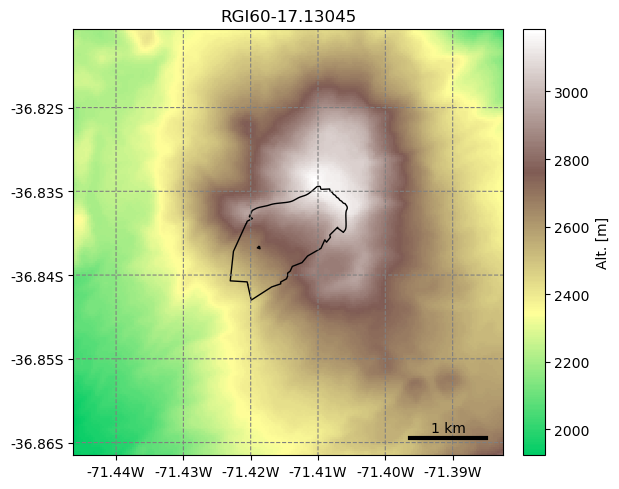

In [16]:
from oggm import graphics
graphics.plot_domain(nevado_gdir, figsize=(6, 5))

Another advantage of glacier directories is their persistence on disk: once created, they can be recovered from the same location by using init_glacier_directories again, but without keyword arguments:

In [17]:
# Fetch the LOCAL pre-processed directories - note that no arguments are used!
#gdirs = workflow.init_glacier_directories(rgi_ids)
nevado_gdirs = workflow.init_glacier_directories(glaciar_nevado)

2024-07-25 17:38:05: oggm.workflow: Execute entity tasks [GlacierDirectory] on 1 glaciers


## Accessing data in the preprocessed directories
Glacier directories are the central object for model users and developpers to access data for this glacier. Let’s say for example that you would like to retrieve the climate data that we have prepared for you. You can ask the glacier directory to tell you where this data is:

In [18]:
#gdir.get_filepath('climate_historical')
#now for nevado: 
nevado_gdir.get_filepath('climate_historical')

'/tmp/OGGM/OGGM-GettingStarted-10m/per_glacier/RGI60-17/RGI60-17.13/RGI60-17.13045/climate_historical.nc'

/opt/conda/envs/oggm_env/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  index_grouper = pd.Grouper(
/opt/conda/envs/oggm_env/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  index_grouper = pd.Grouper(


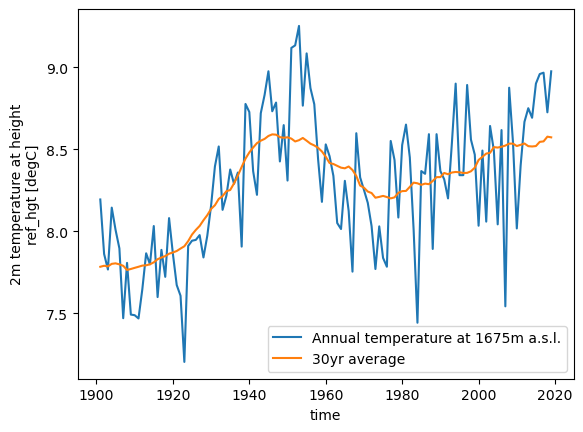

In [19]:
# One can then use familiar tools to read and process the data further:
import xarray as xr
import matplotlib.pyplot as plt
# Open the file for Nevados de Chillán using xarray
with xr.open_dataset(nevado_gdir.get_filepath('climate_historical')) as ds:
    ds = ds.load()
# Plot the data
ds.temp.resample(time='AS').mean().plot(label=f'Annual temperature at {int(ds.ref_hgt)}m a.s.l.');
ds.temp.resample(time='AS').mean().rolling(time=31, center=True, min_periods=15).mean().plot(label='30yr average');
plt.legend();
# got FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead

^^ want to add something here comparing this temperature with the Cr2met in-situ measurements for the valley  

In [20]:
# As a result of the processing workflow the glacier directories can store many more files. 
# If you are interested, you can have a look at the list:
import os
print(os.listdir(nevado_gdir.dir))

['dem.tif', 'model_diagnostics_spinup_historical.nc', 'elevation_band_flowline.csv', 'fl_diagnostics_historical.nc', 'glacier_grid.json', 'inversion_flowlines.pkl', 'intersects.tar.gz', 'mb_calib.json', 'log.txt', 'model_flowlines.pkl', 'inversion_input.pkl', 'model_geometry_spinup_historical.nc', 'downstream_line.pkl', 'model_geometry_historical.nc', 'climate_historical.nc', 'model_diagnostics_historical.nc', 'gridded_data.nc', 'outlines.tar.gz', 'model_flowlines_dyn_melt_f_calib.pkl', 'inversion_output.pkl', 'fl_diagnostics_spinup_historical.nc', 'diagnostics.json', 'dem_source.txt']


## OGGM tasks
There are two different types of “tasks” in OGGM:

Entity Tasks : Standalone operations to be realized on one single glacier entity, independently from the others. The majority of OGGM tasks are entity tasks. They are parallelisable: the same task can run on several glaciers in parallel.

Global Tasks : Tasks which require to work on several glacier entities at the same time. Model parameter calibration or the compilation of several glaciers’ output are examples of global tasks.

OGGM implements a simple mechanism to run a specific task on a list of GlacierDirectory objects. Here, for the sake of the demonstration of how tasks work, we are going to compute something new from the directory:

In [21]:
from oggm import tasks

# run the compute_inversion_velocities task 
workflow.execute_entity_task(tasks.compute_inversion_velocities, nevado_gdirs);

2024-07-25 17:38:06: oggm.workflow: Execute entity tasks [compute_inversion_velocities] on 1 glaciers


Compute inversion velocities is an optional task in the OGGM workflow. It computes the ice velocity along the flowline resulting from the ice flux from a glacier in equilibrium (more on this in the documentation or the dedicated tutorial).

Note that OGGM tasks often do not return anything (the statement above seems to be “void”, i.e. doing nothing). The vast majority of OGGM tasks actually write data to disk in order to retrieve it later. Let’s have a look at the data we just added to the directory:

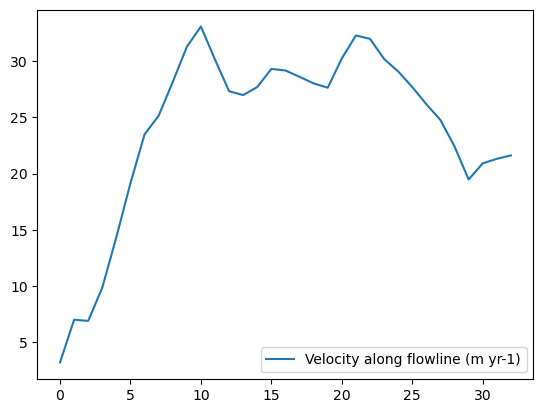

In [22]:
# Computing inversion velocities
nevado_inversion_output = nevado_gdir.read_pickle('inversion_output')  # The task above wrote the data to a pickle file - but we write to plenty of other files!

# Take the first flowline
fl_nev = nevado_inversion_output[0]
# the last grid points often have irrealistic velocities
# because of the equilibrium assumption
nevado_vel = fl_nev['u_surface'][:-1]  
plt.plot(nevado_vel, label='Velocity along flowline (m yr-1)'); plt.legend();

## Computing “elevation band” and “centerline” flowlines
https://oggm.org/tutorials/stable/notebooks/10minutes/elevation_bands_vs_centerlines.html

In [23]:
from oggm import cfg, utils, workflow, graphics, tasks
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
cfg.initialize(logging_level='WARNING')

2024-07-25 17:38:07: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-07-25 17:38:07: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-07-25 17:38:07: oggm.cfg: Multiprocessing: using all available processors (N=2)


In [25]:
# Pick the glacier you want! Here I use Glaciar Nevado 
glaciar_nevado = ['RGI60-17.13045']

# Where to store the data 
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-centerlines', reset=True)

# We start from prepro level 3 with all data ready - note the url here
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/centerlines/W5E5/'
nevado_gdirs = workflow.init_glacier_directories(glaciar_nevado, from_prepro_level=3, prepro_border=80, prepro_base_url=base_url)
nev_gdir_cl = nevado_gdirs[0]
nev_gdir_cl

2024-07-25 17:38:07: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-07-25 17:38:07: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
  0% of 229.2 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
100% of 229.2 MiB |######################| Elapsed Time: 0:00:12 Time:  0:00:12


<oggm.GlacierDirectory>
  RGI id: RGI60-17.13045
  Region: 17: Southern Andes
  Subregion: 17-02: C Andes                         
  Glacier type: Ice cap
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 1.256 km2
  Lon, Lat: (-71.4149, -36.8356)
  Grid (nx, ny): (219, 217)
  Grid (dx, dy): (26.0, -26.0)

In [26]:
# Elevation band flowline
# New working directory
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-elevbands', reset=True)

# Note the new url
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/elev_bands/W5E5/'
nevado_gdirs = workflow.init_glacier_directories(glaciar_nevado, from_prepro_level=3, prepro_border=80, prepro_base_url=base_url)
nev_gdir_eb = nevado_gdirs[0]
nev_gdir_eb

2024-07-25 17:38:21: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-07-25 17:38:21: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
  0% of 214.6 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
100% of 214.6 MiB |######################| Elapsed Time: 0:00:12 Time:  0:00:12


<oggm.GlacierDirectory>
  RGI id: RGI60-17.13045
  Region: 17: Southern Andes
  Subregion: 17-02: C Andes                         
  Glacier type: Ice cap
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 1.256 km2
  Lon, Lat: (-71.4149, -36.8356)
  Grid (nx, ny): (219, 217)
  Grid (dx, dy): (26.0, -26.0)

## Glacier length and cross section

In [27]:
nev_fls_cl = nev_gdir_cl.read_pickle('model_flowlines')
nev_fls_eb = nev_gdir_eb.read_pickle('model_flowlines')

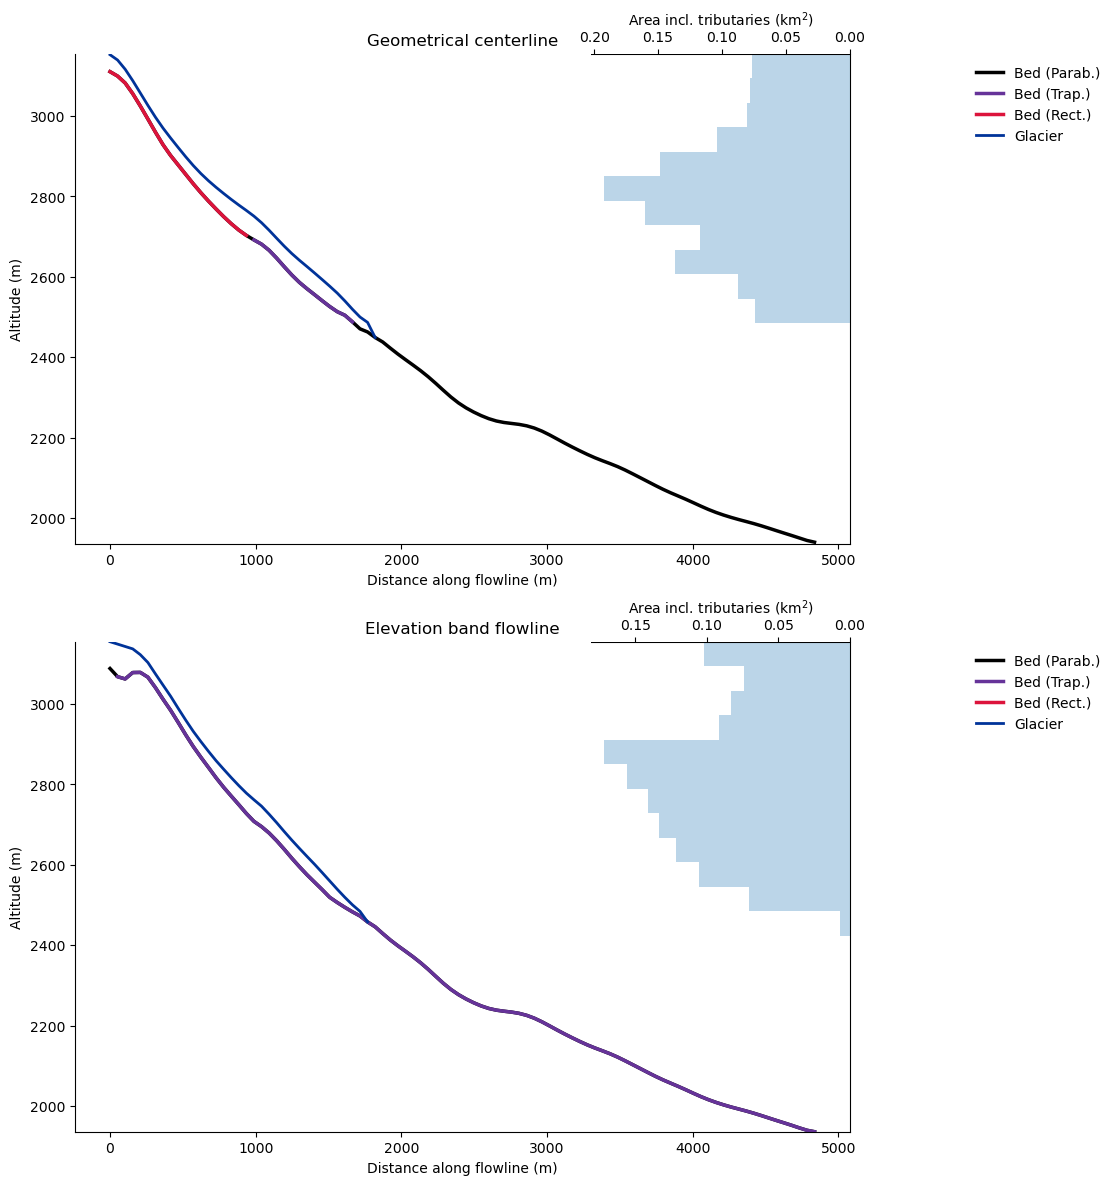

In [28]:
# plot 
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 14), sharex=True, sharey=True)
graphics.plot_modeloutput_section(nev_fls_cl, ax=ax1)
ax1.set_title('Geometrical centerline')
graphics.plot_modeloutput_section(nev_fls_eb, ax=ax2)
ax2.set_title('Elevation band flowline');

Projections: often relatively small differences in volume, but more in geometry
Thanks to OGGM’s modular workflow, simulating both geometries is very similar in terms of code. For example, we can process the climate data for both representations with the same command:

In [29]:
nev_gdirs = [nev_gdir_cl, nev_gdir_eb]

In [30]:
from oggm.shop import gcm_climate

# you can choose one of these 5 different GCMs:
# 'gfdl-esm4_r1i1p1f1', 'mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1' ("low sensitivity" models, within typical ranges from AR6)
# 'ipsl-cm6a-lr_r1i1p1f1', 'ukesm1-0-ll_r1i1p1f2' ("hotter" models, especially ukesm1-0-ll)
member = 'mri-esm2-0_r1i1p1f1' 

for ssp in ['ssp126', 'ssp370','ssp585']:
    # bias correct them
    workflow.execute_entity_task(gcm_climate.process_monthly_isimip_data, nevado_gdirs, 
                                 ssp = ssp,
                                 # gcm member -> you can choose another one
                                 member=member,
                                 # recognize the climate file for later
                                 output_filesuffix=f'_ISIMIP3b_{member}_{ssp}'
                                 );

2024-07-25 17:38:35: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers


  0% of  18.6 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
100% of  18.6 MiB |######################| Elapsed Time: 0:00:01 Time:  0:00:01
  0% of  35.6 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
100% of  35.6 MiB |######################| Elapsed Time: 0:00:02 Time:  0:00:02
  0% of  18.6 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
100% of  18.6 MiB |######################| Elapsed Time: 0:00:01 Time:  0:00:01
  0% of  35.6 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
100% of  35.6 MiB |######################| Elapsed Time: 0:00:02 Time:  0:00:02
2024-07-25 17:38:48: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
  0% of  18.6 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
100% of  18.6 MiB |######################| Elapsed Time: 0:00:01 Time:  0:00:01
  0% of  18.6 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
100% of  18.6 MiB |

For the ice dynamics simulations, the commands are exactly the same as well. The only difference is that centerlines require the more flexible “FluxBased” numerical model, while the elevation bands can also use the more robust “SemiImplicit” one. The runs are considerabily faster with the elevation bands flowlines.

In [31]:
# add additional outputs to default OGGM
cfg.PARAMS['store_model_geometry'] = True  
cfg.PARAMS['store_fl_diagnostics'] = True

for nevado_gdir in nevado_gdirs:
    if nevado_gdir is nev_gdir_cl:
        cfg.PARAMS['evolution_model'] = 'FluxBased'
    else:
        cfg.PARAMS['evolution_model'] = 'SemiImplicit'

    workflow.execute_entity_task(tasks.run_from_climate_data, [nevado_gdir],
                                 output_filesuffix='_historical',  
                                );

    for ssp in ['ssp126', 'ssp370', 'ssp585']:
        rid = f'_ISIMIP3b_{member}_{ssp}'

        workflow.execute_entity_task(tasks.run_from_climate_data, [nevado_gdir],
                                     climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                     climate_input_filesuffix=rid,  # use the chosen scenario
                                     init_model_filesuffix='_historical',  # this is important! Start from 2020 glacier
                                     output_filesuffix=rid,  # recognize the run for later
                                    );

2024-07-25 17:38:59: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.
2024-07-25 17:38:59: oggm.cfg: PARAMS['store_fl_diagnostics'] changed from `False` to `True`.
2024-07-25 17:38:59: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2024-07-25 17:39:00: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2024-07-25 17:39:00: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2024-07-25 17:39:00: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers


In [32]:
rid = f'_ISIMIP3b_{member}_ssp126'

In [33]:
# Both models can be reprensented with a cross-section, like this:
### FileNotFoundError: [Errno 2] No such file or directory: '/tmp/OGGM/OGGM-centerlines/per_glacier/RGI60-17/RGI60-17.13/RGI60-17.13045/fl_diagnostics_ISIMIP3b_mri-esm2-0_r1i1p1f1_ssp126.nc'
### looks like my glacier isn't avilable :/ come back ... 


# sel_years = np.linspace(2020, 2100, 17).astype(int)
# colors = sns.color_palette('rocket', len(sel_years))
# with plt.rc_context({'axes.prop_cycle': plt.cycler(color=colors)}):
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5.5), sharey=True, sharex=True)
#     n_lines = len(nev_gdir_cl.read_pickle('model_flowlines'))
#     with xr.open_dataset(nev_gdir_cl.get_filepath('fl_diagnostics', filesuffix=rid), group=f'fl_{n_lines-1}') as ds:
#         (ds.bed_h + ds.sel(time=sel_years).thickness_m).plot(ax=ax1, hue='time')
#         ds.bed_h.plot(ax=ax1, c='k')
#         ax1.set_title('Centerlines')
#     with xr.open_dataset(nev_gdir_eb.get_filepath('fl_diagnostics', filesuffix=rid), group='fl_0') as ds:
#         (ds.bed_h + ds.sel(time=sel_years).thickness_m).plot(ax=ax2, hue='time')
#         ds.bed_h.plot(ax=ax2, c='k')
#         ax2.set_ylabel('')
#         ax2.set_title('Elevation bands')

## Display glacier area and thickness changes on a grid

In [34]:
from oggm import cfg
from oggm import tasks, utils, workflow, graphics, DEFAULT_BASE_URL
import xarray as xr
import matplotlib.pyplot as plt

In [35]:
# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WARNING')

# Local working directory (where OGGM will write its output)
# WORKING_DIR = utils.gettempdir('OGGM_distr4')
cfg.PATHS['working_dir'] = utils.get_temp_dir('OGGM_distributed', reset=True)

2024-07-25 17:39:01: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-07-25 17:39:01: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-07-25 17:39:01: oggm.cfg: Multiprocessing: using all available processors (N=2)


In [36]:
#rgi_ids = ['RGI60-11.01450']  # This is Aletsch
rgi_ids = ['RGI60-17.13045']  # This is Glacial Nevado

gdir = workflow.init_glacier_directories(rgi_ids, prepro_base_url=DEFAULT_BASE_URL, from_prepro_level=4, prepro_border=80)[0]

2024-07-25 17:39:01: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2024-07-25 17:39:01: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


## Experiment: a random warming simulation
Here we use a random climate, but you can use any GCM, as long as glaciers are getting smaller, not bigger!

In [37]:
# Do a random run with a bit of warming
tasks.run_random_climate(gdir, 
                         ys=2020, ye=2100,  # Although the simulation is idealised, lets use real dates for the animation
                         y0=2009, halfsize=10,  # Randome climate of 1999-2019
                         seed=1,  # Random number generator seed 
                         temperature_bias=1.5,  # additional warming - change for other scenarios
                         store_fl_diagnostics=True,  # important! This will be needed for the redistribution
                         init_model_filesuffix='_spinup_historical',  # start from the spinup run
                         output_filesuffix='_random_s1',  # optional - here I just want to make things explicit as to which run we are using afterwards
                        );

Redistribute: preprocessing
The required tasks can be found in the distribute_2d module of the sandbox:

In [38]:
from oggm.sandbox import distribute_2d

In [39]:
# This is to add a new topography to the file (smoothed differently)
distribute_2d.add_smoothed_glacier_topo(gdir)
# This is to get the bed map at the start of the simulation
tasks.distribute_thickness_per_altitude(gdir)
# This is to prepare the glacier directory for the interpolation (needs to be done only once)
distribute_2d.assign_points_to_band(gdir)

In [40]:
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()

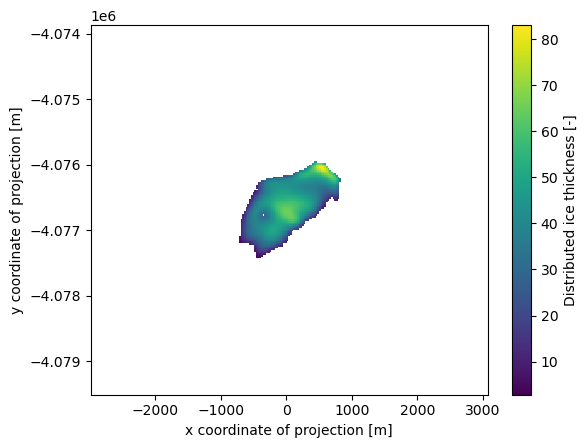

In [41]:
# Inititial glacier thickness
f, ax = plt.subplots()
ds.distributed_thickness.plot(ax=ax);
ax.axis('equal');

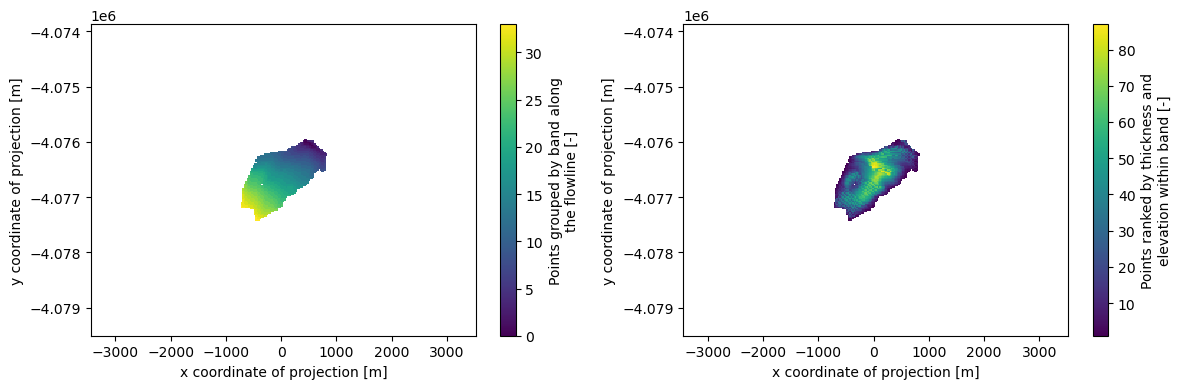

In [42]:
# Which points belongs to which band, and then within one band which are the first to melt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ds.band_index.plot(ax=ax1);
ds.rank_per_band.plot(ax=ax2);
ax1.axis('equal'); ax2.axis('equal'); plt.tight_layout();

Redistribute simulation
The tasks above need to be run only once. The next one however should be done for each simulation:

In [43]:
ds = distribute_2d.distribute_thickness_from_simulation(gdir, 
                                                        input_filesuffix='_random_s1',  # Use the simulation we just did
                                                        concat_input_filesuffix='_spinup_historical',  # Concatenate with the historical spinup
                                                        )

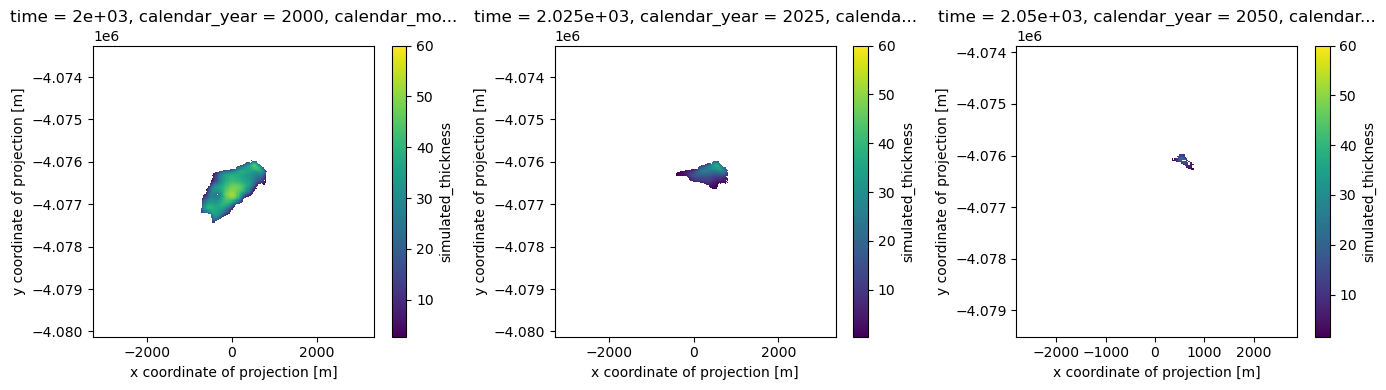

In [44]:
# # Plot
# f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
# ds.distributed_thickness.sel(time=2000).plot(ax=ax1, vmax=400);
# ds.distributed_thickness.sel(time=2050).plot(ax=ax2, vmax=400);
# ds.distributed_thickness.sel(time=2100).plot(ax=ax3, vmax=400);
# ax1.axis('equal'); ax2.axis('equal'); plt.tight_layout();
# was getting an error that distributed thickness wasnt an attribute in the dataset, so trying simulated thickness instead: 
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
ds.simulated_thickness.sel(time=2000).plot(ax=ax1, vmax=60);
ds.simulated_thickness.sel(time=2025).plot(ax=ax2, vmax=60);
ds.simulated_thickness.sel(time=2050).plot(ax=ax3, vmax=60);
ax1.axis('equal'); ax2.axis('equal'); plt.tight_layout();

Really interesting because we're nearly in 2025 and the glacier looks nothing like this - basically still looks like the map of 2000

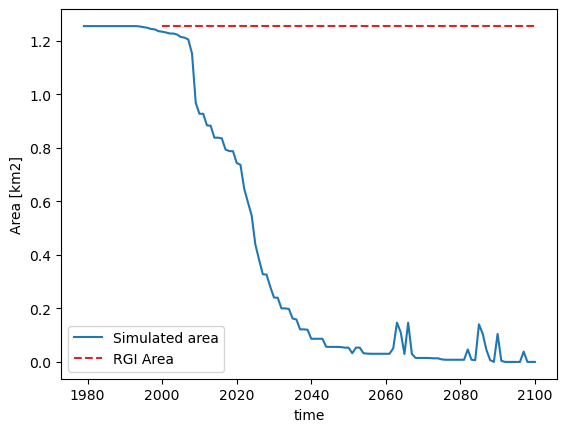

In [45]:
area = (ds.simulated_thickness > 0).sum(dim=['x', 'y']) * gdir.grid.dx**2 * 1e-6
area.plot(label='Simulated area');
plt.hlines(gdir.rgi_area_km2, gdir.rgi_date, 2100, color='C3', linestyles='--', label='RGI Area');
plt.legend(loc='lower left'); plt.ylabel('Area [km2]');

Again this isn't true -- can I improve/inform the model by manually adding polygons for glacier area since 2000?

In [ ]:
# computing mass balance from static directory 
# Get the calibrated mass-balance model - the default is to use OGGM's "MonthlyTIModel"
mbmod = massbalance.MultipleFlowlineMassBalance(gdir)
# i think this is just computing mass balance for glaciar nevado (# 16) 

# Compute the specific MB for this glacier
fls = gdir.read_pickle('model_flowlines')
years = np.arange(1950, 2019)
mb_ts = mbmod.get_specific_mb(fls=fls, year=years)

plt.plot(years, mb_ts);
plt.ylabel('Specific MB (mm w.e.)');
plt.xlabel('Year');

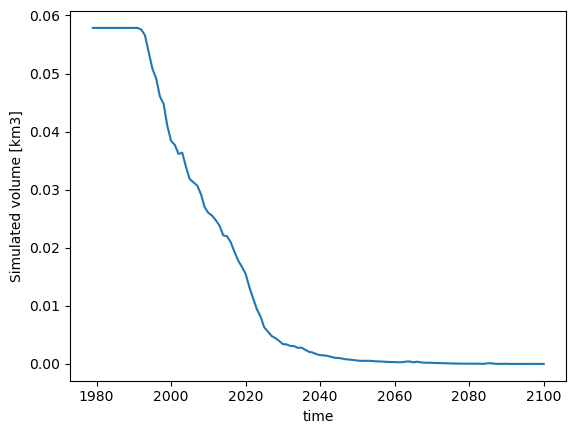

In [46]:
vol = ds.simulated_thickness.sum(dim=['x', 'y']) * gdir.grid.dx**2 * 1e-9
vol.plot(label='Simulated volume'); plt.ylabel('Simulated volume [km3]');

In [47]:
ds = ds.sel(time=slice(gdir.rgi_date, None))

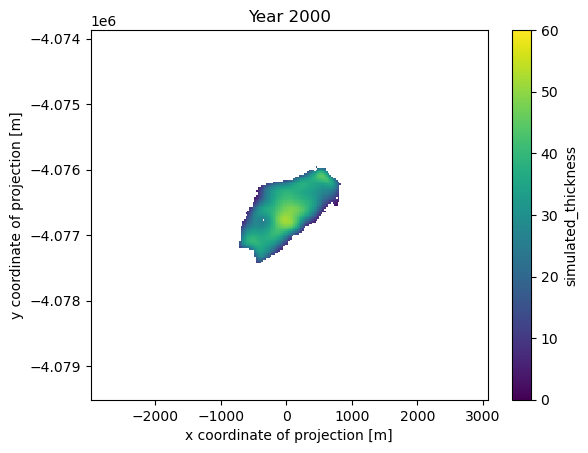

In [48]:
from matplotlib import animation
from IPython.display import HTML, display

# Get a handle on the figure and the axes
fig, ax = plt.subplots()

thk = ds['simulated_thickness']

# Plot the initial frame. 
cax = thk.isel(time=0).plot(ax=ax,
    add_colorbar=True,
    cmap='viridis',
    vmin=0, vmax=60,
    # vmax was originally 350 in the source code, played with it so that the glacier didn't look like all 0 values
    cbar_kwargs={
        'extend':'neither'
    }
)
ax.axis('equal')

def animate(frame):
    ax.set_title(f'Year {int(thk.time[frame])}')
    cax.set_array(thk.values[frame, :].flatten())

ani_glacier = animation.FuncAnimation(fig, animate, frames=len(thk.time), interval=50);
#initial interval was 100, trying 50... 

## Glaciers as water resources part 1: 

let’s have a look at the expected contribution of glaciers to local streamflow. The chart below shows an idealized scenario where the climate is first constant (t
-t
, and the glacier is in equilibrium with its climate) and then a warming occurs (t
-t
). This graph makes a few very important points, which we will explore together in this notebook

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')  # plot defaults 

import xarray as xr
import salem
import numpy as np
import pandas as pd

import oggm.cfg
from oggm import utils, workflow, tasks, graphics
from oggm.sandbox.edu import run_constant_climate_with_bias

In [50]:
# OGGM options
oggm.cfg.initialize(logging_level='WARNING')
oggm.cfg.PATHS['working_dir'] = utils.gettempdir(dirname='WaterResources')
oggm.cfg.PARAMS['min_ice_thick_for_length'] = 1  # a glacier is defined when ice is thicker than 1m
oggm.cfg.PARAMS['store_model_geometry'] = True

2024-07-25 17:39:05: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-07-25 17:39:05: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-07-25 17:39:05: oggm.cfg: Multiprocessing: using all available processors (N=2)
2024-07-25 17:39:05: oggm.cfg: PARAMS['min_ice_thick_for_length'] changed from `0.0` to `1`.
2024-07-25 17:39:05: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.


In [51]:
# Glaciar Nevado 
rgi_id = 'RGI60-17.13045'

In [52]:
# We pick the elevation-bands glaciers because they run a bit faster - but they create more step changes in the area outputs
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/elev_bands/W5E5'
gdir = workflow.init_glacier_directories([rgi_id], from_prepro_level=5, prepro_border=80, prepro_base_url=base_url)[0]

2024-07-25 17:39:06: oggm.workflow: init_glacier_directories from prepro level 5 on 1 glaciers.
2024-07-25 17:39:06: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
  0% of  44.8 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
100% of  44.8 MiB |######################| Elapsed Time: 0:00:03 Time:  0:00:03


In [53]:
# Interactive Glacier Map
# One interactive plot below requires Bokeh
try:
    import holoviews as hv
    hv.extension('bokeh')
    import geoviews as gv
    import geoviews.tile_sources as gts

    sh = salem.transform_geopandas(gdir.read_shapefile('outlines'))
    out = (gv.Polygons(sh).opts(fill_color=None, color_index=None) * 
           gts.tile_sources['EsriImagery'] * 
           gts.tile_sources['StamenLabels']).opts(width=800, height=500, active_tools=['pan', 'wheel_zoom'])
except:
    # The rest of the notebook works without this dependency
    out = None
out

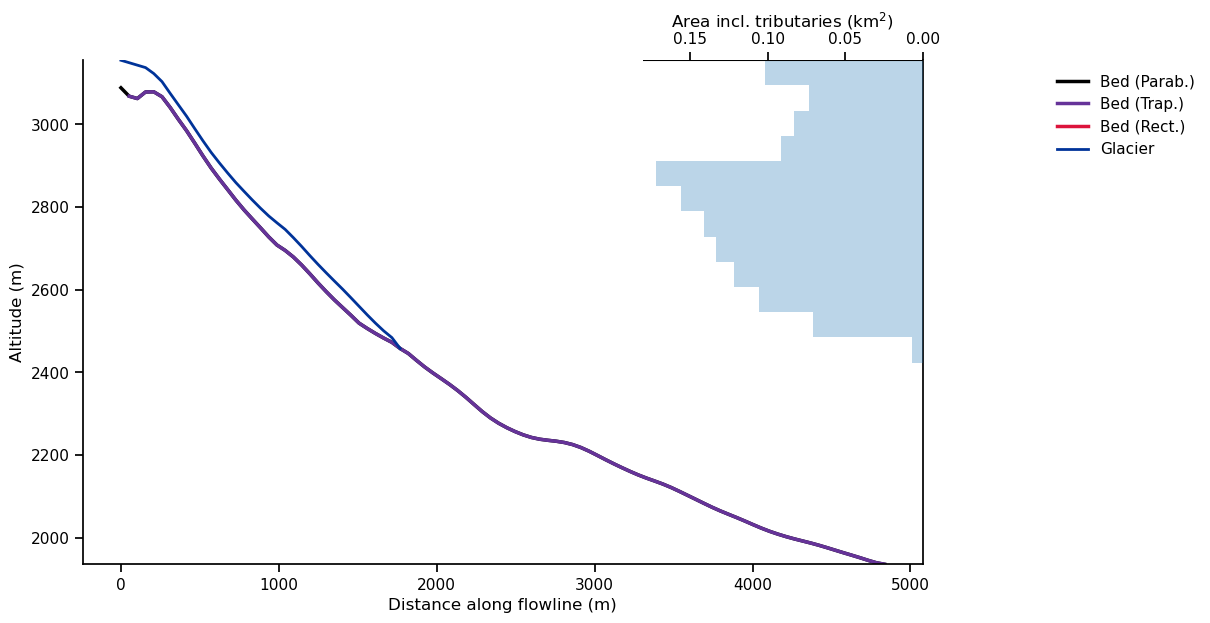

In [54]:
# For OGGM, glaciers are “1.5” dimensional along their flowline:
fls = gdir.read_pickle('model_flowlines')
graphics.plot_modeloutput_section(fls);

## Generating a glacier in equilibrium with climate
Let’s prepare a run with the run_constant_climate_with_bias tasks from the oggm_edu package. It allows us to run idealized temperature and precipitation correction scenarios in an easy way.

First, let’s decide on a temperature evolution:

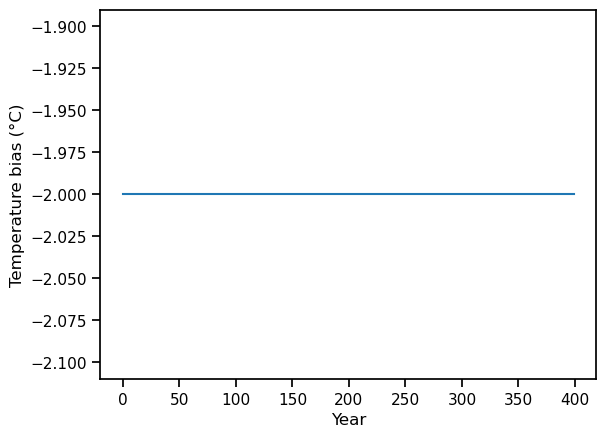

In [55]:
years = np.arange(400)
temp_bias_ts = pd.Series(years * 0. - 2, index=years)
temp_bias_ts.plot(); plt.xlabel('Year'); plt.ylabel('Temperature bias (°C)');

Not much to see here! The temp_bias_ts variable describes a temperature bias that will be applied to the standard climate (see below).

Here the bias is -2° all along because we want to run a so-called “spinup” run, to let the glacier grow and make sure that our glacier is in dynamical equilibrium with its climate at the end of the simulation. Let’s go:

In [56]:
# file identifier where the model output is saved
file_id = '_spinup'

# We are using the task run_with_hydro to store hydrological outputs along with the usual glaciological outputs
tasks.run_with_hydro(gdir,  # Run on the selected glacier
                     temp_bias_ts=temp_bias_ts,  # the temperature bias to apply to the average climate
                     run_task=run_constant_climate_with_bias,  # which climate scenario? See following notebook for other examples
                     y0=2009, halfsize=10,  # Period which we will average and constantly repeat
                     store_monthly_hydro=True,  # Monthly ouptuts provide additional information
                     output_filesuffix=file_id);  # an identifier for the output file, to read it later

OK so there is quite some new material in the cell above. Let’s focus on the most important points:

we run the model for 400 years (as defined by our control temperature timeseries)

the model runs with a constant climate averaged over 21 years (2 times halfsize + 1) for the period 1999-2019

we apply a cold bias of -2°C. Indeed, Hintereisferner is in strong disequilibrium with the current climate and such a bias is needed to make the glacier grow (more on this later)

In [57]:
# Now Let’s have a look at the output now:
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
    # The last step of hydrological output is NaN (we can't compute it for this year)
    ds = ds.isel(time=slice(0, -1)).load()

In [58]:
#list variables in this dataset with: 
ds 
# Tip: you can click on a variable and show it’s attribute with the “page” button on the right.


<xarray.Dataset> Size: 294kB
Dimensions:                       (time: 399, month_2d: 12)
Coordinates:
  * time                          (time) float64 3kB 0.0 1.0 2.0 ... 397.0 398.0
    calendar_year                 (time) int64 3kB 0 1 2 3 4 ... 395 396 397 398
    calendar_month                (time) int64 3kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
    hydro_year                    (time) int64 3kB 0 1 2 3 4 ... 395 396 397 398
    hydro_month                   (time) int64 3kB 10 10 10 10 ... 10 10 10 10
  * month_2d                      (month_2d) int64 96B 1 2 3 4 5 ... 9 10 11 12
    hydro_month_2d                (month_2d) int64 96B 10 11 12 1 2 ... 6 7 8 9
    calendar_month_2d             (month_2d) int64 96B 1 2 3 4 5 ... 9 10 11 12
Data variables: (12/21)
    volume_m3                     (time) float64 3kB 5.025e+07 ... 1.199e+08
    volume_bsl_m3                 (time) float64 3kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    volume_bwl_m3                 (time) float64 3kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    area_m2                       (time) float64 3kB 1.256e+06 ... 2.102e+06
    length_m                      (time) float64 3kB 1.768e+03 ... 3.432e+03
    calving_m3                    (time) float64 3kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                            ...
    liq_prcp_on_glacier           (time) float64 3kB 3.549e+07 ... 1.535e+08
    liq_prcp_on_glacier_monthly   (time, month_2d) float64 38kB 1.527e+07 ......
    snowfall_off_glacier          (time) float64 3kB 1.95e+09 ... 3.217e+06
    snowfall_off_glacier_monthly  (time, month_2d) float64 38kB 2.25e+05 ... ...
    snowfall_on_glacier           (time) float64 3kB 3.068e+09 ... 5.04e+09
    snowfall_on_glacier_monthly   (time, month_2d) float64 38kB 2.344e+07 ......
Attributes:
    description:          OGGM model output
    oggm_version:         0.1.dev1+g3354bee
    calendar:             365-day no leap
    creation_date:        2024-07-25 17:39:11
    water_level:          0
    glen_a:               8.362937521525281e-24
    fs:                   0
    mb_model_class:       BiasedConstantMassBalance
    mb_model_hemisphere:  sh
    mb_model_rho:         900.0
    mb_model_ys:          0
    mb_model_ye:          399

The time and month_2d variables are coordinates, and the other variables are either provided as additional information (e.g. hydro_month, we will get back to this), or they are providing the actual data. For instance, we can plot the annual evolution of the volume and length of our glacier:

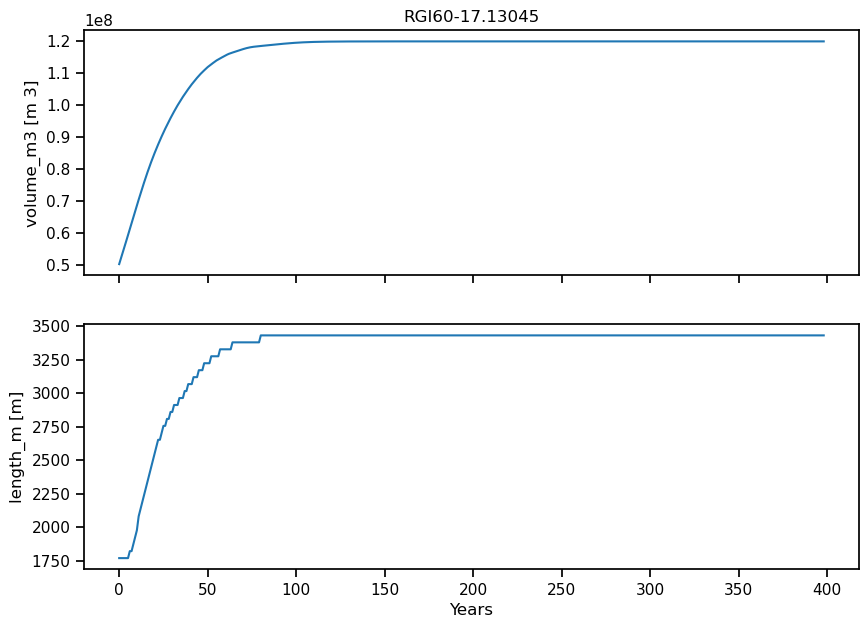

In [59]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 7), sharex=True)
ds.volume_m3.plot(ax=axs[0]);
ds.length_m.plot(ax=axs[1]);
axs[0].set_xlabel(''); axs[0].set_title(f'{rgi_id}'); axs[1].set_xlabel('Years');

The glacier grows and almost doubles its volume. After ~100 years, it is in equilibrium.

This spinup simulation won’t be analyzed further: let’s jump to the heart of the topic: what happens with glacier runoff when climate is warming?



## Climate change simulation
We start by generating a temperature change scenario. We define a short period of constant temperature (at -2°C, to be consistent with above), followed by a linear increase (2.5 degrees in about 150 years) and a stabilization:

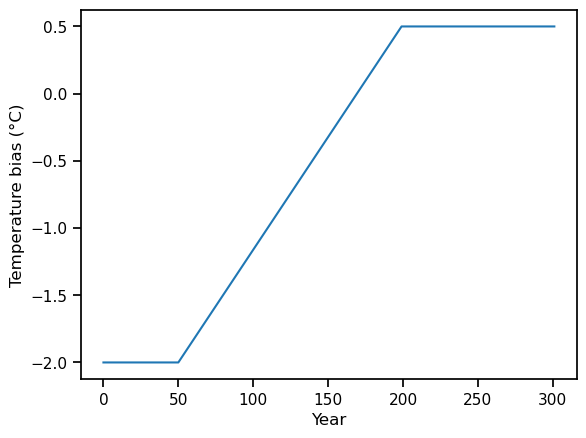

In [60]:
ny_s = 50  # Start
ny_t = 150  # Trend
ny_e = 102  # Stabilisation
temp_bias_ts = np.concatenate([np.full(ny_s, -2.), np.linspace(-2, 0.5, ny_t), np.full(ny_e, 0.5)])
temp_bias_ts = pd.Series(temp_bias_ts, index=np.arange(ny_s + ny_t + ny_e))
temp_bias_ts.plot(); plt.xlabel('Year'); plt.ylabel('Temperature bias (°C)');

In [61]:
# file identifier where the model output is saved
file_id = '_lin_temp'

# We are using the task run_with_hydro to store hydrological outputs along with the usual glaciological outputs
tasks.run_with_hydro(gdir,
                     temp_bias_ts=temp_bias_ts,  # the temperature bias timeseries we just created
                     run_task=run_constant_climate_with_bias,  # which climate scenario? See following notebook for other examples
                     y0=2009, halfsize=10,  # Period which we will average and constantly repeat
                     store_monthly_hydro=True,  # Monthly ouptuts provide additional information
                     init_model_filesuffix='_spinup',  # We want to start from the glacier in equibrium we created earlier
                     output_filesuffix=file_id);  # an identifier for the output file, to read it later

In [62]:
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
    # The last step of hydrological output is NaN (we can't compute it for this year)
    ds = ds.isel(time=slice(0, -1)).load()

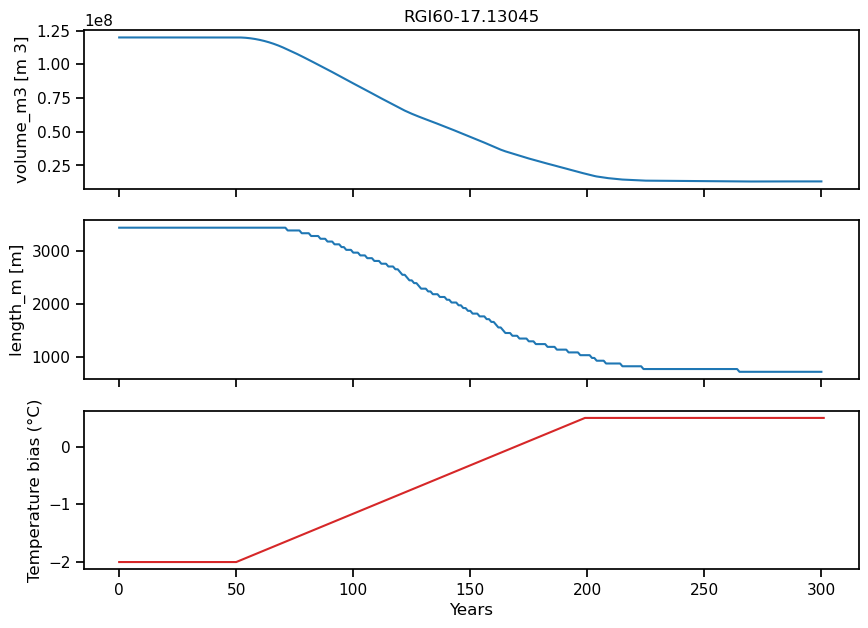

In [63]:
fig, axs = plt.subplots(nrows=3, figsize=(10, 7), sharex=True)
ds.volume_m3.plot(ax=axs[0]);
ds.length_m.plot(ax=axs[1]);
temp_bias_ts.plot(ax=axs[2], c='C3');
axs[0].set_xlabel(''); axs[0].set_title(f'{rgi_id}'); axs[1].set_xlabel(''); axs[2].set_xlabel('Years'); axs[2].set_ylabel('Temperature bias (°C)');

In this scenario, the glacier would melt almost entirely (it looses about 90% of its volume). Note also that the glacier continues to adjust after the temperature has stabilized. What are the implications for downstream runoff?

## Annual runoff
As glaciers retreat, they contribute to sea level rise (visit the World Glaciers Explorer OGGM-Edu app for more information!). This is not what we are interested in here. Indeed, they will also have important local impacts: in this notebook, we will have a look at their impact on streamflow.

Let’s take a look at some of the hydrological outputs computed by OGGM. We start by creating a pandas DataFrame of all “1D” (annual) variables in the output dataset:

In [64]:
sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
df_annual = ds[sel_vars].to_dataframe()

Then we can select the hydrological variables and sum them to get the total annual runoff:

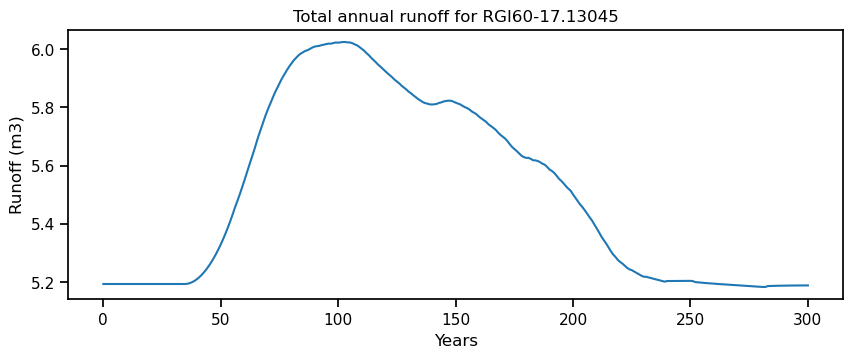

In [65]:
# Select only the runoff variables
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']

# Convert them to megatonnes (instead of kg) - this is what the tutorial did, eventually hash out for my purposes because I want m3
df_runoff = df_annual[runoff_vars] * 1e-9

# 0.001 cubic meters per kg of water - want to convert from kg to m3 for MHM model 
# df_runoff = df_annual[runoff_vars] * 1e-3

# We smooth the output, which is otherwize noisy because of area discretization
df_runoff = df_runoff.rolling(31, center=True, min_periods=1).mean()
fig, ax = plt.subplots(figsize=(10, 3.5), sharex=True)
df_runoff.sum(axis=1).plot(ax=ax);
plt.ylabel('Runoff (m3)'); plt.xlabel('Years'); plt.title(f'Total annual runoff for {rgi_id}');

In [66]:
df_runoff.to_csv('runoff_output.csv', index=False)  # Set index=False to exclude row numbers

^ since the temp spin up takes 200 years, I think that this means that peak runoff was reached before 2000? 

The hydrological variables are computed on the largest possible area that was covered by glacier ice during the simulation. This is equivalent to the runoff that would be measured at a fixed-gauge hydrological station at the glacier terminus.

The total annual runoff consists of the following components:

* melt off-glacier: snow melt on areas that are now glacier free (i.e. 0 in the year of largest glacier extent, in this example at the start of the simulation)

* melt on-glacier: ice + seasonal snow melt on the glacier

* liquid precipitaton on- and off-glacier (the latter being zero at the year of largest glacial extent, in this example at start of the simulation)

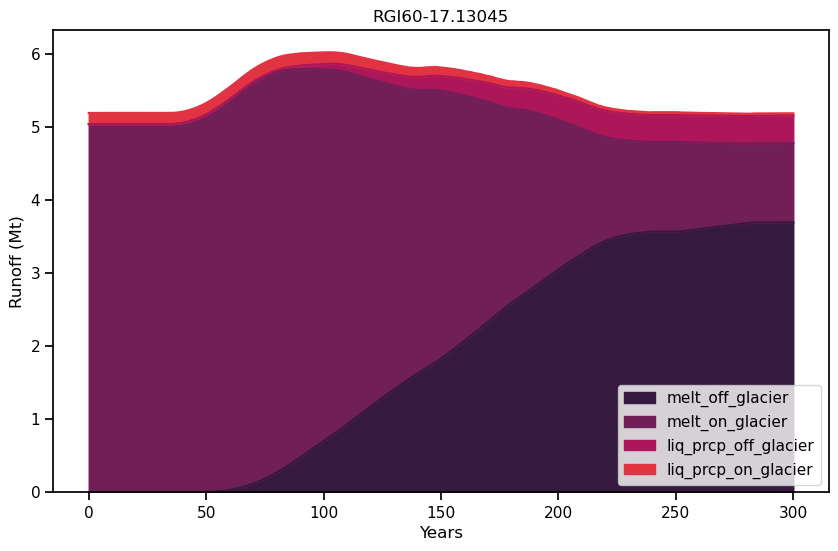

In [67]:
f, ax = plt.subplots(figsize=(10, 6));
df_runoff.plot.area(ax=ax, color=sns.color_palette('rocket')); plt.xlabel('Years'); plt.ylabel('Runoff (Mt)'); plt.title(rgi_id);

The glacier length and volume decrease from year 50 onwards until about year 250 - this is the glacier retreat phase. Afterwards, length and volume stabilize at a constant value indicating that the glacier has reached equilibrium.

Now study the graph above and it’s four main components.

Questions to address:

When is “peak water” reached? Does this have anything to do with a change in the temperature trend itself? If not, what is the reason for “peak water” to occur?

Verify that the total fixed-gauge runoff (remember what this means?) is the same at the beginning and the end of the simulation. Why is that so? What changed in between?

The temperature stabilizes at year 200, yet all hydrological variables continue to change after that. What is happening there?

What is the contribution of liquid precipitation at the beginning and the end of the simulation? What changed?

Can you verify that the net glacier contribution to runoff (i.e. - 
) is zero at the beginning and the end of the simulation and positive in between? Why do we expect this behavior?

Hint: compare the results to the idealised runoff graphic that we introduced at the beginning of this chapter

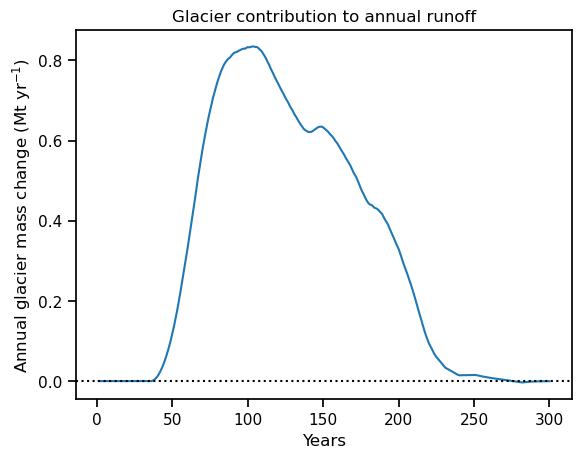

In [68]:
# Solution of the last question above
glacier_mass = ds.volume_m3.to_series() * oggm.cfg.PARAMS['ice_density'] * 1e-9  # In Megatonnes, Mt
glacier_mass = glacier_mass.rolling(31, center=True, min_periods=1).mean()
(- glacier_mass.diff()).plot()
plt.axhline(y=0, color='k', ls=':')
plt.ylabel('Annual glacier mass change (Mt yr$^{-1}$)')
plt.xlabel('Years'); plt.title('Glacier contribution to annual runoff');

## Monthly runoff
The “2D” variables contain the same hydrological data, but at monthly resolution (dimensions [time, month]). For example, monthly runoff can be computed as:

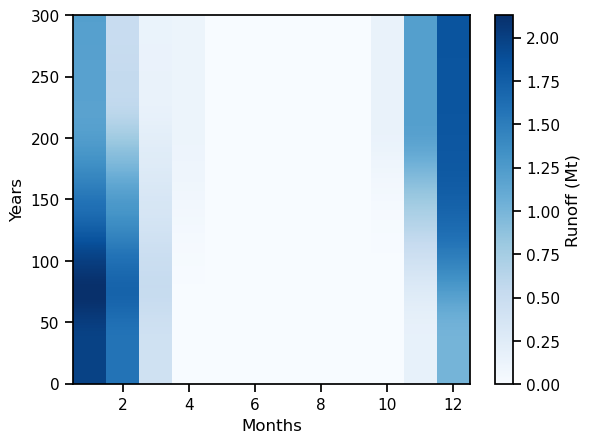

In [69]:
# Select only the runoff variables and convert them to megatonnes (instead of kg)
monthly_runoff = ds['melt_off_glacier_monthly'] + ds['melt_on_glacier_monthly'] + ds['liq_prcp_off_glacier_monthly'] + ds['liq_prcp_on_glacier_monthly']
monthly_runoff = monthly_runoff.rolling(time=31, center=True, min_periods=1).mean() * 1e-9
monthly_runoff.clip(0).plot(cmap='Blues', cbar_kwargs={'label': 'Runoff (Mt)'}); plt.xlabel('Months'); plt.ylabel('Years');

As we can see, the runoff is approximately zero during the winter months, while relatively high during the summer months.

Now let’s compare the actual runoff to total precipitation over the basin:

In [70]:
# Compute total precipitation (Snow + Liquid)
tot_precip = ds['liq_prcp_off_glacier_monthly'] + ds['liq_prcp_on_glacier_monthly'] + ds['snowfall_off_glacier_monthly'] + ds['snowfall_on_glacier_monthly']
tot_precip *= 1e-9  # in Mt

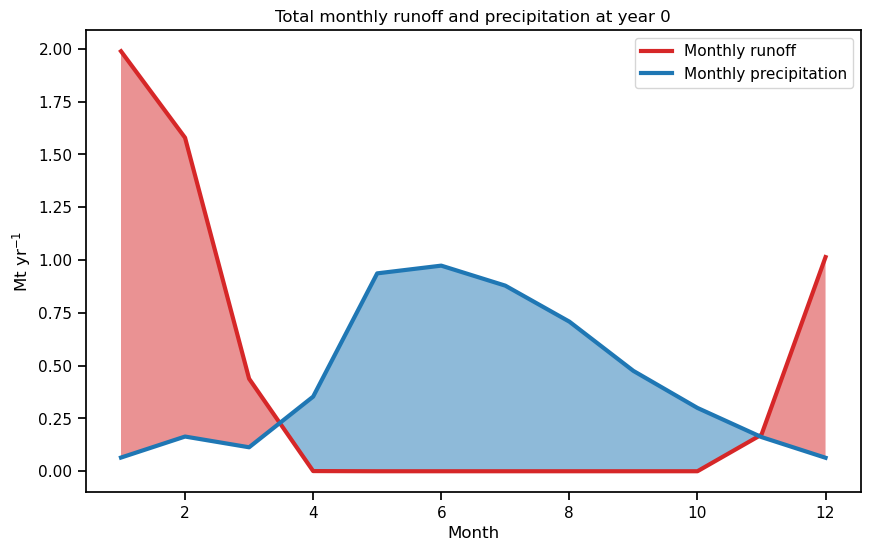

In [71]:
# Plot these data at year 0
yr = 0
r = monthly_runoff.sel(time=yr)
p = tot_precip.sel(time=yr)

f, ax = plt.subplots(figsize=(10, 6));
r.plot(ax=ax, color='C3', label='Monthly runoff', linewidth=3);
p.plot(ax=ax, color='C0', label='Monthly precipitation', linewidth=3);
ax.fill_between(r.month_2d, r, p, where=(p >= r), facecolor='C0', interpolate=True, alpha=0.5)
ax.fill_between(r.month_2d, r, p, where=(r > p), facecolor='C3', interpolate=True, alpha=0.5)
plt.ylabel('Mt yr$^{-1}$'); plt.legend(loc='best');
plt.xlabel('Month'); plt.title(f'Total monthly runoff and precipitation at year {yr}');

"At the begining of the simulation, the glacier is in equilibrium and its annual contribution to runoff is zero. In fact, this means that the blue area in the plot above is equal to the red area: the glaciated basin releases water during the summer, that accumulated in form of snow in the winter months.

In this region (Ötztal Alps, Austria), precipitation is relatively constant throughout the year. Discuss what the implications could be in other climates of the world, in particular in climates with a strong seasonality of precipitation.

Now let’s have a look at the seasonal change in runoff with time:"

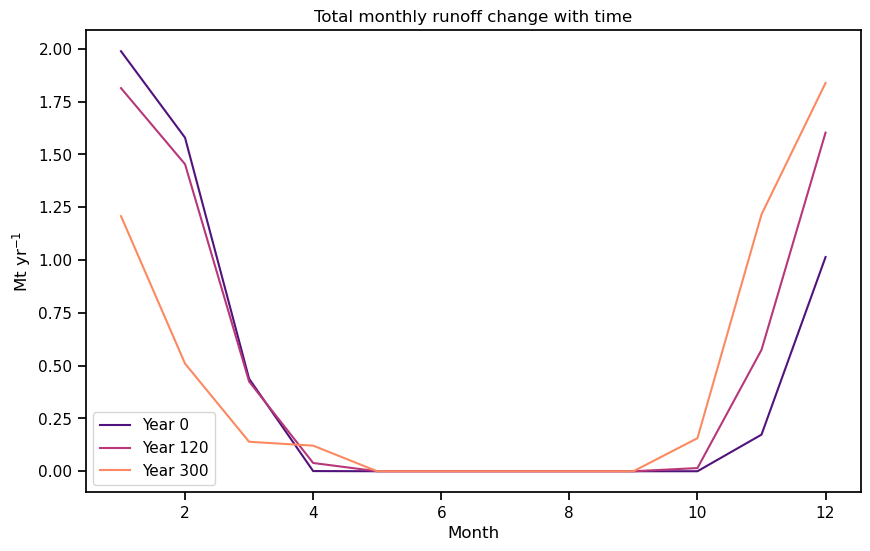

In [72]:
f, ax = plt.subplots(figsize=(10, 6));
cmap = sns.color_palette('magma', 3)
for i, yr in enumerate([0, 120, 300]):
    monthly_runoff.sel(time=yr).plot(ax=ax, color=cmap[i], label=f'Year {yr}')
plt.ylabel('Mt yr$^{-1}$'); plt.legend(loc='best');
plt.xlabel('Month'); plt.title('Total monthly runoff change with time');

* see earlier spring/summer melt in the future, with melt contributions drying up sooner (around Feb). 
* decrease in monthly runoff in the future, suggests we've already passed or are close to passing peak water 

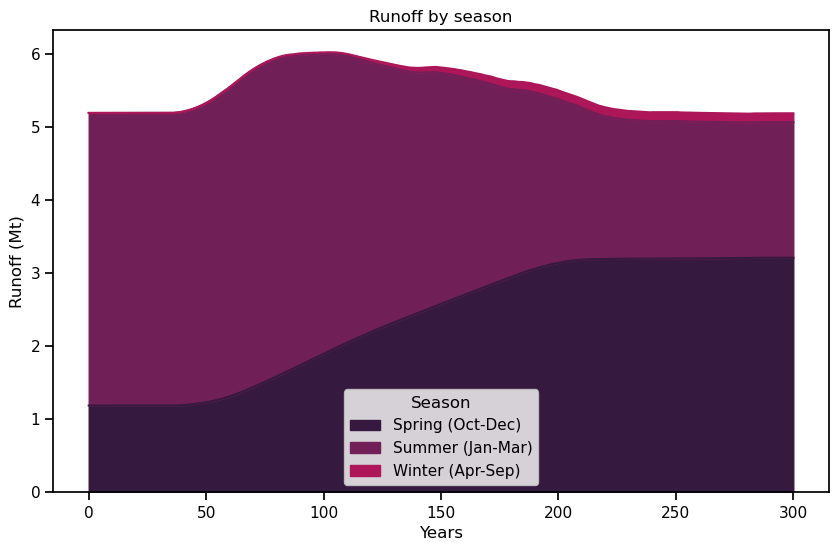

In [73]:
# Make a dataframe out of the xarray dataset for simplicity
df_monthly_runoff = pd.DataFrame(monthly_runoff.data, index=ds.time, columns=monthly_runoff.month_2d)

# Create new columns for each season (we define seasons from the perspective of the northern Hemisphere)
df_monthly_runoff['Spring (Oct-Dec)'] = df_monthly_runoff[[10, 11, 12]].sum(axis=1)
df_monthly_runoff['Summer (Jan-Mar)'] = df_monthly_runoff[[1, 2, 3]].sum(axis=1)
df_monthly_runoff['Winter (Apr-Sep)'] = df_monthly_runoff[[4, 5, 6, 7, 8, 9]].sum(axis=1)
df_monthly_runoff.columns.name = 'Season'

# Plot it
# Attention the seasons and labels might need to be adapted if a glacier in a different region is used!
f, ax = plt.subplots(figsize=(10, 6));
df_monthly_runoff[['Spring (Oct-Dec)', 'Summer (Jan-Mar)', 'Winter (Apr-Sep)']].plot.area(ax=ax, color=sns.color_palette('rocket'));
plt.xlabel('Years'); plt.ylabel('Runoff (Mt)'); plt.title('Runoff by season');

In [74]:
# Export monthly glacier discharge to use in MHM 

#df_monthly_runoff.to_csv('glaciermeltoutput.csv', index=False)  # Set index=False to exclude row numbers


* shows an increase in spring melt going forward, a decrease in summer melt
* around 50 years seems like an increase in runoff? perhaps we haven't reached peak runoff then

Now replicate Huss and Hock (2018) figure

<>:11: SyntaxWarning: invalid escape sequence '\D'
<>:11: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_20776/3424745185.py:11: SyntaxWarning: invalid escape sequence '\D'
  ax2.legend(loc='lower right'); ax2.set_xlabel('Years'); ax2.set_ylabel('$\Delta T (°C)$');


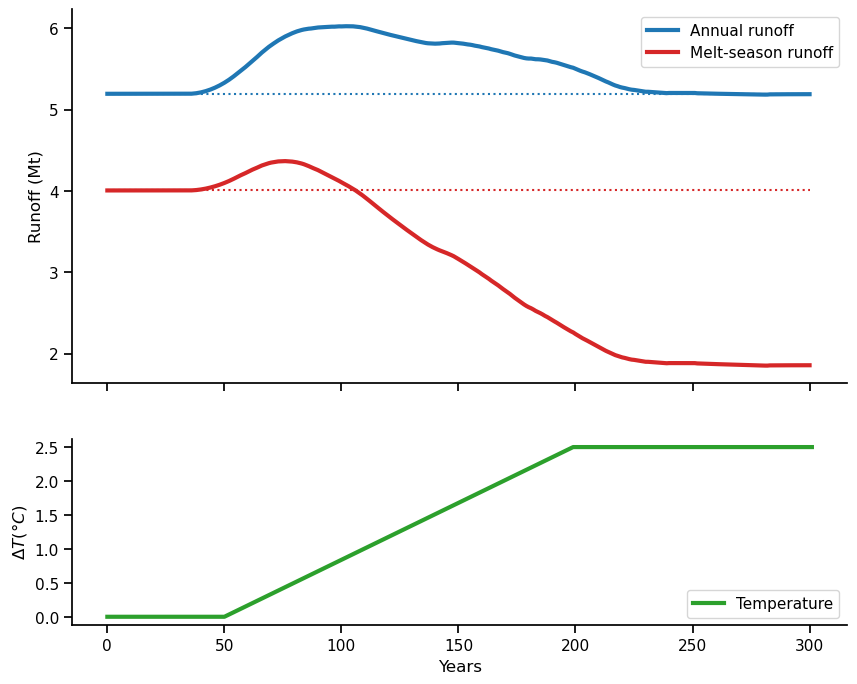

In [75]:
f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, figsize=(10, 8), sharex=True)

p1 = df_monthly_runoff[['Spring (Oct-Dec)', 'Summer (Jan-Mar)', 'Winter (Apr-Sep)']].sum(axis=1)
p2 = df_monthly_runoff['Summer (Jan-Mar)'] # January to March is here the melt season
p1.plot(ax=ax1, color='C0', label='Annual runoff', linewidth=3)
p2.plot(ax=ax1, color='C3', label='Melt-season runoff', linewidth=3);
ax1.hlines([p1.loc[0], p2.loc[0]], 0, 300, color=['C0', 'C3'], linestyle=[':']);
ax1.legend(); ax1.set_xlabel(''); ax1.set_ylabel('Runoff (Mt)');

(temp_bias_ts + 2).plot(ax=ax2, color='C2', label='Temperature', linewidth=3);
ax2.legend(loc='lower right'); ax2.set_xlabel('Years'); ax2.set_ylabel('$\Delta T (°C)$');
sns.despine();

* in this simulation glacier reaches peak runoff about 50-100 years after warming is induced

## Quickly going through water resources pt 2

In [76]:
type(out)

NoneType

In [77]:
import holoviews
holoviews.core.overlay.Overlay

ModuleNotFoundError: No module named 'holoviews'

Past run
The glacier directories we are using come with a run called a “spinup”, which is a simulation running from 1980 to 2020 while appoximately matching glacier volume and area at the glacier outline date:



In [ ]:
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_spinup_historical')) as ds:
    ds = ds.sel(time=slice(2000, 2020)).load()

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/OGGM/WaterResources/per_glacier/RGI60-17/RGI60-17.13/RGI60-17.13045/model_diagnostics_spinup_historical.nc'

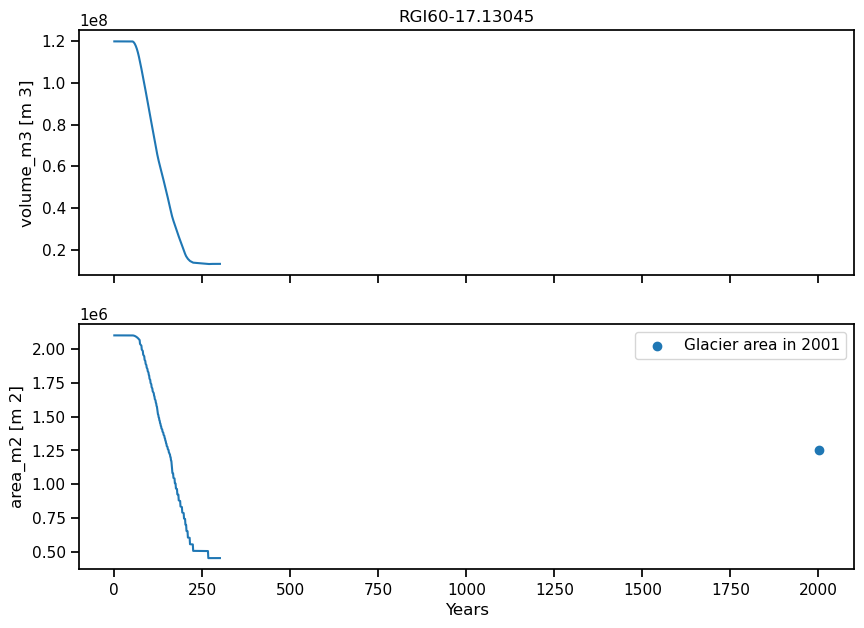

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 7), sharex=True)
ds.volume_m3.plot(ax=axs[0]);
ds.area_m2.plot(ax=axs[1]);
axs[1].scatter(gdir.rgi_date+1, gdir.rgi_area_m2, label=f'Glacier area in {gdir.rgi_date+1}');
axs[0].set_xlabel(''); axs[0].set_title(f'{rgi_id}'); axs[1].set_xlabel('Years'); plt.legend();

## hmm not sure what's wrong here, need to come back 

From now on we will use the glacier area and volume as of 2020 to start our simulations.

“Commitment run”
We are now ready to run our first simulation. This is a so called “commitment run”: how much ice loss is “already committed” for this glacier, even if climate change would stop today? This is a useful but purely theoretical experiment: climate change won’t stop today, unfortunately. To learn more about committed mass-loss at the global scale, read Marzeion et al., 2018.

Here, we run a simulation for 100 years with a constant climate based on the last 11 years:

In [ ]:
# file identifier where the model output is saved
file_id = '_ct'

# We are using the task run_with_hydro to store hydrological outputs along with the usual glaciological outputs
tasks.run_with_hydro(gdir,
                     run_task=tasks.run_constant_climate,  # which climate? See below for other examples
                     nyears=100,  # length of the simulation
                     y0=2014, halfsize=5,  # For the constant climate, period over which the climate is taken from
                     init_model_filesuffix='_spinup_historical',  # Start from the glacier in 2020 afer spinup
                     store_monthly_hydro=True,  # Monthly ouptuts provide additional information
                     output_filesuffix=file_id);  # an identifier for the output file to read it later

2024-04-29 01:20:35: oggm.core.flowline: FileNotFoundError occurred during task flowline_model_run_ct on RGI60-17.13045: [Errno 2] No such file or directory: '/tmp/OGGM/WaterResources/per_glacier/RGI60-17/RGI60-17.13/RGI60-17.13045/model_geometry_spinup_historical.nc'
2024-04-29 01:20:35: oggm.core.flowline: FileNotFoundError occurred during task run_constant_climate_ct on RGI60-17.13045: [Errno 2] No such file or directory: '/tmp/OGGM/WaterResources/per_glacier/RGI60-17/RGI60-17.13/RGI60-17.13045/model_geometry_spinup_historical.nc'
2024-04-29 01:20:35: oggm.core.flowline: FileNotFoundError occurred during task run_with_hydro_ct on RGI60-17.13045: [Errno 2] No such file or directory: '/tmp/OGGM/WaterResources/per_glacier/RGI60-17/RGI60-17.13/RGI60-17.13045/model_geometry_spinup_historical.nc'


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/OGGM/WaterResources/per_glacier/RGI60-17/RGI60-17.13/RGI60-17.13045/model_geometry_spinup_historical.nc'

In [ ]:
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
    # The last step of hydrological output is NaN (we can't compute it for this year)
    ds = ds.isel(time=slice(0, -1)).load()

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/OGGM/WaterResources/per_glacier/RGI60-17/RGI60-17.13/RGI60-17.13045/model_diagnostics_ct.nc'

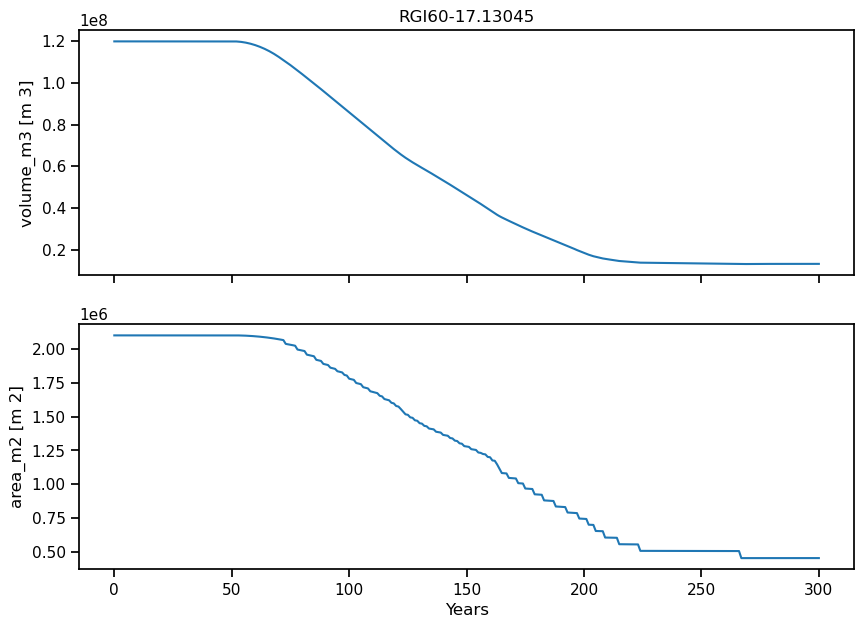

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 7), sharex=True)
ds.volume_m3.plot(ax=axs[0]);
ds.area_m2.plot(ax=axs[1]);
axs[0].set_xlabel(''); axs[0].set_title(f'{rgi_id}'); axs[1].set_xlabel('Years');

Annual runoff
As glaciers retreat, they contribute to sea-level rise (visit the World Glaciers Explorer OGGM-Edu app for more information!). This is not what we are interested in here. Indeed, they will also have important local impacts: in this notebook, we will have a look at their impact on streamflow.

Let’s take a look at some of the hydrological outputs computed by OGGM. We start by creating a pandas DataFrame of all “1D” (annual) variables:

In [ ]:
sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
df_annual = ds[sel_vars].to_dataframe()

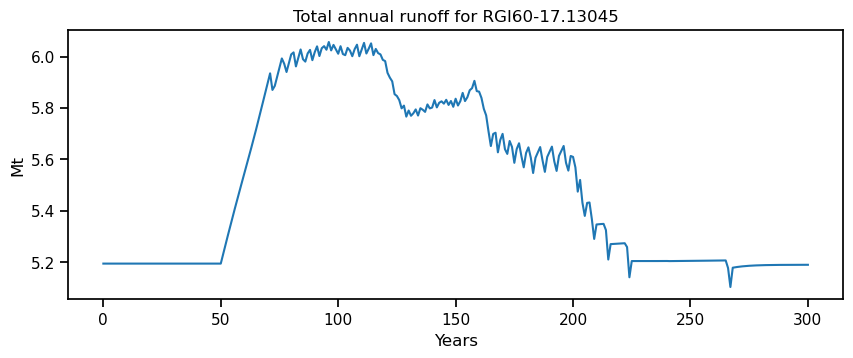

In [ ]:
#Then we can select the hydrological varialbes and sum them to get the total annual runoff:

# Select only the runoff variables
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
# Convert them to megatonnes (instead of kg)
df_runoff = df_annual[runoff_vars] * 1e-9
fig, ax = plt.subplots(figsize=(10, 3.5), sharex=True)
df_runoff.sum(axis=1).plot(ax=ax);
plt.ylabel('Mt'); plt.xlabel('Years'); plt.title(f'Total annual runoff for {rgi_id}');

The hydrological variables are computed on the largest possible area that was covered by glacier ice during the simulation. This is equivalent to the runoff that would be measured at a fixed-gauge hydrological station at the glacier terminus.

The total annual runoff consists of the following components:

melt off-glacier: snow melt on areas that are now glacier free (i.e. 0 in the year of largest glacier extent, in this example at the start of the simulation)

melt on-glacier: ice + seasonal snow melt on the glacier

liquid precipitaton on- and off-glacier (the latter being zero at the year of largest glacial extent, in this example at start of the simulation)

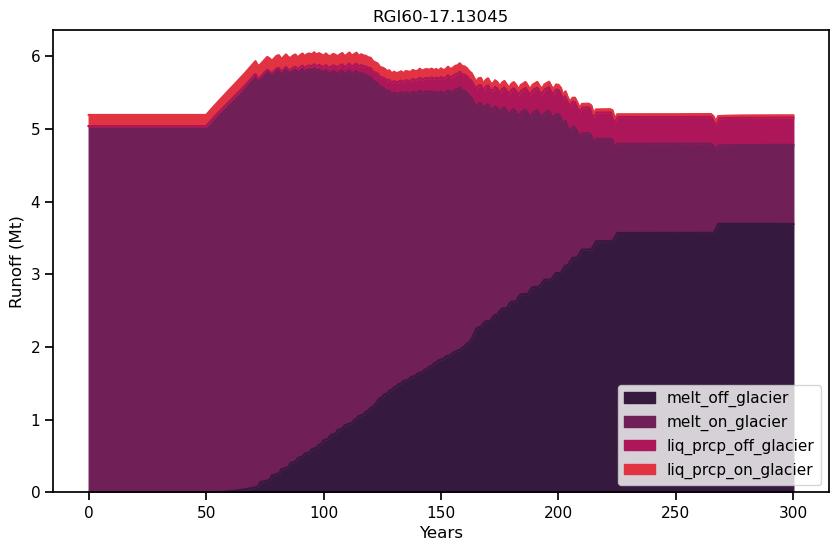

In [ ]:
f, ax = plt.subplots(figsize=(10, 6));
df_runoff.plot.area(ax=ax, color=sns.color_palette("rocket")); plt.xlabel('Years'); plt.ylabel('Runoff (Mt)'); plt.title(rgi_id);

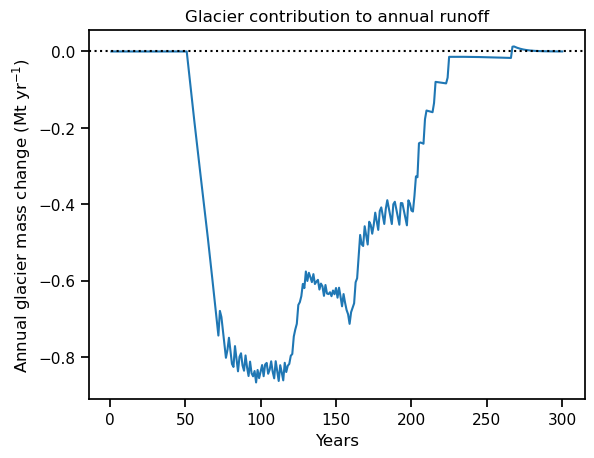

In [ ]:
glacier_mass = ds.volume_m3.to_series() * oggm.cfg.PARAMS['ice_density'] * 1e-9  # In Megatonnes, Mt

glacier_mass.diff().plot()
plt.axhline(y=0, color='k', ls=':')
plt.ylabel('Annual glacier mass change (Mt yr$^{-1}$)')
plt.xlabel('Years'); plt.title('Glacier contribution to annual runoff');

.... this isnt possible what?? ^ 

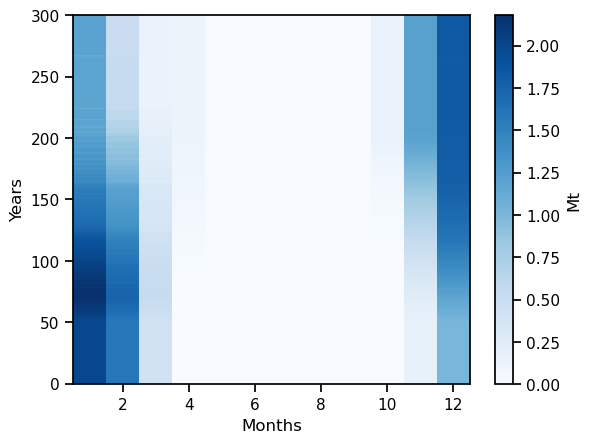

In [ ]:
# Select only the runoff variables and convert them to megatonnes (instead of kg)
monthly_runoff = (ds['melt_off_glacier_monthly'] + ds['melt_on_glacier_monthly'] +
                  ds['liq_prcp_off_glacier_monthly'] + ds['liq_prcp_on_glacier_monthly'])
monthly_runoff *= 1e-9
monthly_runoff.clip(0).plot(cmap='Blues', cbar_kwargs={'label': 'Mt'}); plt.xlabel('Months'); plt.ylabel('Years');

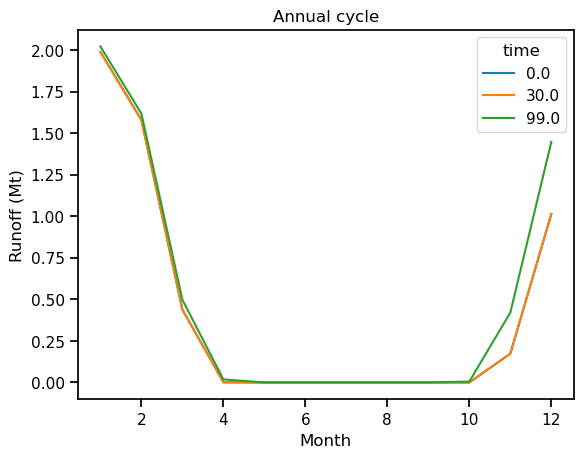

In [ ]:
monthly_runoff.sel(time=[0, 30, 99]).plot(hue='time');
plt.title('Annual cycle');
plt.xlabel('Month');
plt.ylabel('Runoff (Mt)');

21st century projection runs
You have now learned how to simulate and analyse a specific glacier under a constant climate. We will now take this a step further and simulate two different glaciers, located in different climatic regions, forced with CMIP5 climate projections.

We begin by initializing the glacier directories:

In [ ]:
gdirs = workflow.init_glacier_directories(rgi_id, from_prepro_level=5, prepro_border=160, prepro_base_url=base_url)

2024-04-29 01:20:50: oggm.workflow: init_glacier_directories from prepro level 5 on 1 glaciers.
2024-04-29 01:20:50: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


## Climate projections data
Before we run our future simulation we have to process the climate data for the glacier. We are using the bias-corrected projections from the Inter-Sectoral Impact Model Intercomparison Project (ISIMIP). They are offering climate projections from CMIP6 (the basis for the IPCC AR6) but already bias-corrected to our glacier grid point. Let’s download them:

In [ ]:
# you can choose one of these 5 different GCMs:
# 'gfdl-esm4_r1i1p1f1', 'mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1' ("low sensitivity" models, within typical ranges from AR6)
# 'ipsl-cm6a-lr_r1i1p1f1', 'ukesm1-0-ll_r1i1p1f2' ("hotter" models, especially ukesm1-0-ll)
from oggm.shop import gcm_climate
member = 'mri-esm2-0_r1i1p1f1' 

# Download the three main SSPs
for ssp in ['ssp126', 'ssp370','ssp585']:
    # bias correct them
    workflow.execute_entity_task(gcm_climate.process_monthly_isimip_data, gdirs, 
                                 ssp = ssp,
                                 # gcm member -> you can choose another one
                                 member=member,
                                 # recognize the climate file for later
                                 output_filesuffix=f'_ISIMIP3b_{member}_{ssp}'
                                 );

2024-04-29 01:20:54: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2024-04-29 01:20:55: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2024-04-29 01:20:56: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers


## Now can run forced simulations: 

In [ ]:
for ssp in ['ssp126', 'ssp370', 'ssp585']:
    rid = f'_ISIMIP3b_{member}_{ssp}'
    workflow.execute_entity_task(tasks.run_with_hydro, gdir,
                             run_task=tasks.run_from_climate_data, ys=2020,
                             # use gcm_data, not climate_historical
                             climate_filename='gcm_data',
                             # use the chosen scenario
                             climate_input_filesuffix=rid,
                             # this is important! Start from 2020 glacier
                             init_model_filesuffix='_spinup_historical',
                             # recognize the run for later
                             output_filesuffix=rid,
                             # add monthly diagnostics
                             store_monthly_hydro=True);
    

2024-04-29 01:20:56: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2024-04-29 01:20:56: oggm.core.flowline: FileNotFoundError occurred during task run_from_climate_data_ISIMIP3b_mri-esm2-0_r1i1p1f1_ssp126 on RGI60-17.13045: [Errno 2] No such file or directory: '/tmp/OGGM/WaterResources/per_glacier/RGI60-17/RGI60-17.13/RGI60-17.13045/model_geometry_spinup_historical.nc'
2024-04-29 01:20:56: oggm.core.flowline: FileNotFoundError occurred during task run_with_hydro_ISIMIP3b_mri-esm2-0_r1i1p1f1_ssp126 on RGI60-17.13045: [Errno 2] No such file or directory: '/tmp/OGGM/WaterResources/per_glacier/RGI60-17/RGI60-17.13/RGI60-17.13045/model_geometry_spinup_historical.nc'


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/OGGM/WaterResources/per_glacier/RGI60-17/RGI60-17.13/RGI60-17.13045/model_geometry_spinup_historical.nc'

TypeError: 'GlacierDirectory' object is not subscriptable

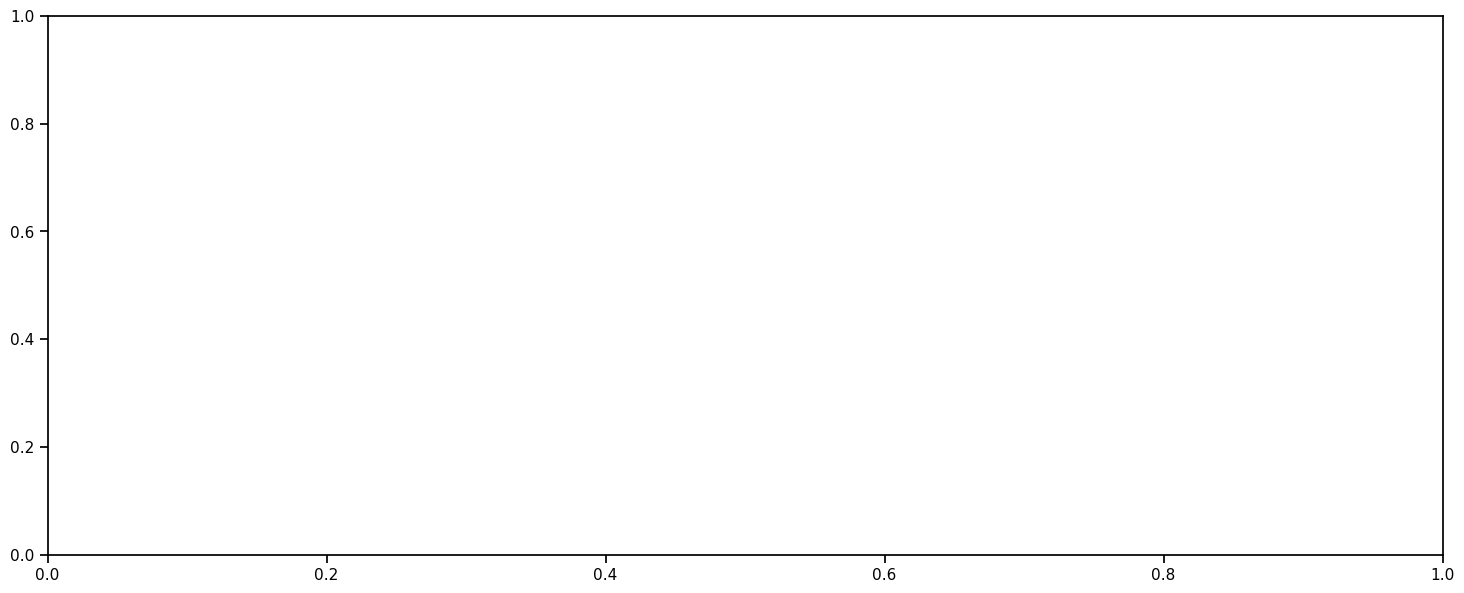

In [ ]:
# Create the figure
f, ax = plt.subplots(figsize=(18, 7), sharex=True)
# Loop over all scenarios
for i, ssp in enumerate(['ssp126', 'ssp370', 'ssp585']):
    file_id = f'_ISIMIP3b_{member}_{ssp}'
    # Open the data, gdirs[0] correspond to Hintereisferner.
    with xr.open_dataset(gdir[0].get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
        # Load the data into a dataframe
        ds = ds.isel(time=slice(0, -1)).load()

    # Select annual variables
    sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
    # And create a dataframe
    df_annual = ds[sel_vars].to_dataframe()

    # Select the variables relevant for runoff.
    runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
    # Convert to mega tonnes instead of kg.
    df_runoff = df_annual[runoff_vars].clip(0) * 1e-9
    # Sum the variables each year "axis=1", take the 11 year rolling mean and plot it.
    df_roll = df_runoff.sum(axis=1).rolling(window=11, center=True).mean()
    df_roll.plot(ax=ax, label=ssp, color=sns.color_palette("rocket")[i])

ax.set_ylabel('Annual runoff (Mt)'); ax.set_xlabel('Year'); plt.title(gdirs[0].rgi_id); plt.legend();

In [ ]:
# %%capture
# %%bash
# jupyter nbconvert tutorials_test.ipynb --to html --no-input
HTML(ani_glacier.to_jshtml())

NameError: name 'HTML' is not defined